In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import PyMieScatt as ps
import subprocess
import math
import sys
import pandas as pd
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras

from scipy import interpolate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB  # Pas utilisé, cela illustre mon echec de la méthode de Naïve Bayes
from sklearn.cluster import KMeans # Pareil pour la méthode KMeans
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

indreal, indimg, sig = 1.62, 0.61, 1.8 # ne pas modifier pour l'instant

lw, ms = 1, 0.02

particle_name = 'water-sigma1.8bae'

def BAE_lognormal_fn(diam, sig, indreal, indimg) :
    Q_1064= ps.Mie_Lognormal(complex(indreal,indimg),1064,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_532=ps.Mie_Lognormal(complex(indreal,indimg),532,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 
    Q_355=ps.Mie_Lognormal(complex(indreal,indimg),355,sig,diam,1e3,asDict=True, lower=0.1, upper=30000) 

    BAE_1064_532 = -np.log(Q_1064['Bback']/ Q_532['Bback'])/np.log(1064/532)
    BAE_532_355 = -np.log(Q_532['Bback']/ Q_355['Bback'])/np.log(532/355)
    BAE_1064_355 = -np.log(Q_1064['Bback']/ Q_355['Bback'])/np.log(1064/355)

    return BAE_1064_532, BAE_532_355, BAE_1064_355

# Importation des données (Calculé par le GMM, ne pas oublier de télécharger les fichiers csv)
df_BAE = np.array(pd.read_csv("BAElognorm.csv"))
df_diam = np.array(pd.read_csv("diam.csv"))

#définitions du jeu de données pour les différents modèles
diam_entree = df_diam[0:714] # Charger les données diamètre

BAE_1064_532 = df_BAE[0:714,0] #On rogne à 715 points car au dessus d'un diamètres de 10^4 cela n'a plus d'intérêt
BAE_532_355 = df_BAE[0:714,1]
BAE_1064_355 = df_BAE[0:714,2]
BAEs = np.array([BAE_1064_532, BAE_532_355, BAE_1064_355]).T

In [2]:
start = time.time()

inputs = diam_entree.reshape(-1, 1) # convertir en format pour le réseau de neurones
outputs = np.column_stack((BAE_1064_532, BAE_532_355, BAE_1064_355))

# Modèle du réseau de neurones
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(1,)), # Couche d'entrée
    keras.layers.Dense(32, activation='relu'), # Couche cachée
    keras.layers.Dense(3) # Couche de sortie
])
# Compilation du modèle
model.compile(optimizer='Adam', loss='mean_squared_error') # Adam est le plus efficace pour ce réseau

# Entraînement du modèle
model.fit(inputs, outputs, epochs=100, verbose=0)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 100000)
BAE_nouveau = model.predict(diametre_nouveau.reshape(-1, 1))

end = time.time()
tmps_1 = end - start

# Évaluation du modèle
train_predictions = model.predict(inputs)
train_mse_1 = mean_squared_error(outputs, train_predictions)
val_predictions = model.predict(inputs)
val_mse_1 = mean_squared_error(outputs, val_predictions)
train_mae_1 = mean_absolute_error(outputs, train_predictions)
val_mae_1 = mean_absolute_error(outputs, val_predictions)
train_r2_1 = r2_score(outputs, train_predictions)
val_r2_1 = r2_score(outputs, val_predictions)


23/23 [==============================] - 0s 1ms/step


In [3]:
start = time.time()

# Séparation des données en entrée et sortie
input_d = np.column_stack((diam_entree, np.full((diam_entree.shape[0], 1), sig),
                              np.full((diam_entree.shape[0], 1), indreal),
                              np.full((diam_entree.shape[0], 1), indimg)))

output_d = np.column_stack((BAE_1064_532, BAE_532_355, BAE_1064_355))

train_input, val_input, train_output, val_output = train_test_split(input_d, output_d, test_size=0.2, random_state=42) 

# Création du modèle de réseau de neurones
model = keras.Sequential()
model.add(keras.layers.Dense(32, input_shape=(4,), activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='linear'))

# Compilation du modèle
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mae'])

# Entraînement du modèle
history = model.fit(train_input, train_output, epochs=100, verbose=0, validation_data=(val_input, val_output))

# Évaluation du modèle
_, train_mae = model.evaluate(train_input, train_output, verbose=0)
_, val_mae = model.evaluate(val_input, val_output, verbose=0)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 100000)
input_nouveau = np.column_stack((diametre_nouveau, np.full((diametre_nouveau.shape[0], 1), sig),
                              np.full((diametre_nouveau.shape[0], 1), indreal),
                              np.full((diametre_nouveau.shape[0], 1), indimg)))
BAE_nouveau = model.predict(input_nouveau)

end = time.time()
tmps_2 = end - start

# Calcul des prédictions pour l'ensemble d'entraînement et de validation
train_predictions = model.predict(train_input)
val_predictions = model.predict(val_input)

# Calcul des métriques d'évaluation
train_mse_2 = mean_squared_error(train_output, train_predictions)
val_mse_2 = mean_squared_error(val_output, val_predictions)
train_mae_2 = mean_absolute_error(train_output, train_predictions)
val_mae_2 = mean_absolute_error(val_output, val_predictions)
train_r2_2 = r2_score(train_output, train_predictions)
val_r2_2 = r2_score(val_output, val_predictions)

5/5 [==============================] - 0s 868us/step


In [4]:
start = time.time()

# Séparation des données en entrée et sortie
input_d = np.column_stack((diam_entree, np.full((diam_entree.shape[0], 1), sig),
                              np.full((diam_entree.shape[0], 1), indreal),
                              np.full((diam_entree.shape[0], 1), indimg)))

output_d = np.column_stack((BAE_1064_532, BAE_532_355, BAE_1064_355))

# Séparation des données en ensemble d'entraînement et de validation
train_input, val_input, train_output, val_output = train_test_split(input_d, output_d, test_size=0.2, random_state=42) 

# Création du modèle random forest
model = RandomForestRegressor(n_estimators=100)

# Entraînement du modèle
model.fit(train_input, train_output)

# Évaluation du modèle
train_error = model.score(train_input, train_output)
val_error = model.score(val_input, val_output)

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 10000)
input_nouveau = np.column_stack((diametre_nouveau, np.full((diametre_nouveau.shape[0], 1), sig),
                              np.full((diametre_nouveau.shape[0], 1), indreal),
                              np.full((diametre_nouveau.shape[0], 1), indimg)))
BAE_nouveau = model.predict(input_nouveau)

end = time.time()
tmps_3 = end - start

# Calcul des prédictions pour l'ensemble d'entraînement et de validation
train_predictions = model.predict(train_input)
val_predictions = model.predict(val_input)

# Calcul des métriques d'évaluation
train_mse_3 = mean_squared_error(train_output, train_predictions)
val_mse_3 = mean_squared_error(val_output, val_predictions)
train_mae_3 = mean_absolute_error(train_output, train_predictions)
val_mae_3 = mean_absolute_error(val_output, val_predictions)
train_r2_3 = r2_score(train_output, train_predictions)
val_r2_3 = r2_score(val_output, val_predictions)

In [5]:
start = time.time()

# Séparation des données en entrée et sortie
diam_entree = diam_entree.reshape(-1, 1)
BAE_sortie = np.array(BAEs)

# Séparation des données en ensemble d'entraînement et de validation
train_input, val_input, train_output, val_output = train_test_split(diam_entree, BAEs, test_size=0.2, random_state=42) 

# Conversion des données en format Dmatrix pour XGBoost
dtrain = xgb.DMatrix(train_input, label=train_output)
dval = xgb.DMatrix(val_input, label=val_output)

# Paramétrage de XGBoost
params = {'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'seed': 42}

# Entraînement du modèle
model = xgb.train(params, dtrain, num_boost_round=100)

# Évaluation du modèle
train_error = model.eval(dtrain)[1]
val_error = model.eval(dval)[1]

# Génération de nouvelles données pour tracer les prédictions
diametre_nouveau = np.linspace(np.min(diam_entree), np.max(diam_entree), 10000).reshape(-1, 1)
dtest = xgb.DMatrix(diametre_nouveau)
BAE_nouveau = model.predict(dtest)

end = time.time()
tmps_4 = end - start

# Calcul des métriques d'évaluation
train_pred = model.predict(dtrain)
val_pred = model.predict(dval)
train_mse_4 = mean_squared_error(train_output, train_pred)
val_mse_4 = mean_squared_error(val_output, val_pred)
train_mae_4 = mean_absolute_error(train_output, train_pred)
val_mae_4 = mean_absolute_error(val_output, val_pred)
train_r2_4 = r2_score(train_output, train_pred)
val_r2_4 = r2_score(val_output, val_pred)

[08:41:03] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [6]:
start = time.time()

diam_entree = diam_entree.reshape(-1, 1)
BAE_sortie = np.array(BAEs)

# Instancier et entrainer le modèle k-NN
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(diam_entree, BAE_sortie)

# Prédire les valeurs de BAE en utilisant le modèle k-NN
diam_pred = np.linspace(diam_entree.min(), diam_entree.max(), 1000000).reshape(-1, 1)
BAE_pred = knn.predict(diam_pred)

end = time.time()
tmps_5 = end - start

# Calcul des métriques d'évaluation
mse_5 = mean_squared_error(BAE_sortie, knn.predict(diam_entree))
mae_5 = mean_absolute_error(BAE_sortie, knn.predict(diam_entree))
r2_5 = r2_score(BAE_sortie, knn.predict(diam_entree))

In [7]:
start = time.time()

diam_entree = diam_entree.reshape(-1, 1)
BAE_sortie = np.array(BAEs)

# Séparer les données en données d'entraînement et données de test
diam_entree_train, diam_entree_test, BAE_sortie_train, BAE_sortie_test = train_test_split(diam_entree, BAE_sortie, test_size=0.2)

# Définir le modèle
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(1,), activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3)
])

# Compiler le modèle
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Entraîner le modèle
history = model.fit(diam_entree_train, BAE_sortie_train, epochs=100, verbose =0, validation_data=(diam_entree_test, BAE_sortie_test))

# Génération de nouvelles données pour tracer les prédictions
diam_nouveau = np.linspace(diam_entree.min(), diam_entree.max(), 1000000).reshape(-1, 1)
BAE_nouveau = model.predict(diam_nouveau)
diametre_nouveau = diam_nouveau.reshape(1000000)

end = time.time()
tmps_6 = end - start

# Calcul des prédictions pour l'ensemble d'entraînement et de validation
train_predictions = model.predict(diam_entree_train)
val_predictions = model.predict(diam_entree_test)

# Calcul des métriques d'évaluation
train_mse_6 = mean_squared_error(train_output, train_predictions)
val_mse_6 = mean_squared_error(BAE_sortie_test, val_predictions)
train_mae_6 = mean_absolute_error(train_output, train_predictions)
val_mae_6 = mean_absolute_error(BAE_sortie_test, val_predictions)
train_r2_6 = r2_score(BAE_sortie_train, train_predictions)
val_r2_6 = r2_score(BAE_sortie_test, val_predictions)

5/5 [==============================] - 0s 868us/step


In [8]:
start = time.time()

#Ajuster des splines sur les points de données
BAE_spline_1064_532 = interpolate.interp1d(diam_entree.squeeze(), BAE_1064_532, kind='cubic')
BAE_spline_532_355 = interpolate.interp1d(diam_entree.squeeze(), BAE_532_355, kind='cubic')
BAE_spline_1064_355 = interpolate.interp1d(diam_entree.squeeze(), BAE_1064_355, kind='cubic')

#Estimer les BAE pour des diamètres qui ne sont pas dans la liste originale
BAE_new_1064_532 = BAE_spline_1064_532(diam_entree)
BAE_new_532_355 = BAE_spline_532_355(diam_entree)
BAE_new_1064_355 = BAE_spline_1064_355(diam_entree)
BAEs_new = np.concatenate((BAE_new_1064_532.reshape(-1,1), BAE_new_532_355.reshape(-1,1), BAE_new_1064_355.reshape(-1,1)), axis=1)

end = time.time()
tmps_7 = end - start

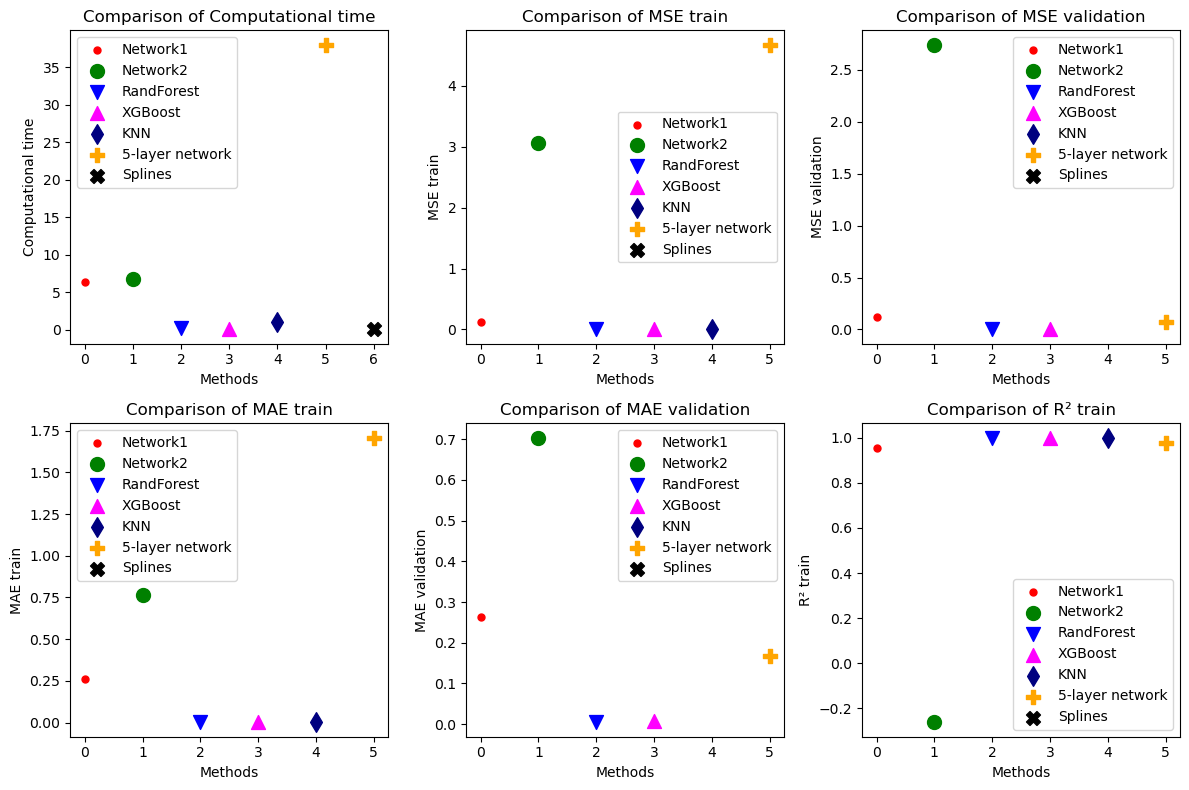

In [11]:
# Stockage des valeurs de MSE et R² dans des listes
tmps_values = [tmps_1, tmps_2, tmps_3, tmps_4, tmps_5, tmps_6, tmps_7]
train_mse_values = [train_mse_1, train_mse_2, train_mse_3, train_mse_4, mse_5, train_mse_6, None]
val_mse_values = [val_mse_1, val_mse_2, val_mse_3, val_mse_4, None, val_mse_6, None]
train_r2_values = [train_r2_1, train_r2_2, train_r2_3, train_r2_4, r2_5, train_r2_6, None]
val_r2_values = [val_r2_1, val_r2_2, val_r2_3, val_r2_4, None, val_r2_6, None]
train_mae_values = [train_mae_1, train_mae_2, train_mae_3, train_mae_4, mae_5, train_mae_6, None]
val_mae_values = [val_mae_1, val_mae_2, val_mae_3, val_mae_4, None, val_mae_6, None]

# Graphiques pour les différentes métriques
metrics = ['tmps', 'train_mse', 'val_mse', 'train_mae', 'val_mae', 'train_r2', 'val_r2']
names = ["Computational time", "MSE train", "MSE validation",
         "MAE train", "MAE validation","R² train", "R² validation"]
methods = ['Network1', 'Network2', 'RandForest', 'XGBoost', 'KNN', '5-layer network', 'Splines']
colors = ['red', 'green', 'blue', 'magenta', 'navy', 'orange', 'black']
markers = ['.', 'o', 'v', '^', 'd', 'P', 'X']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

for i, ax in enumerate(axes.ravel()):
    if i < len(metrics):
        for j, method in enumerate(methods):
            ax.scatter(j, eval(metrics[i].lower() + '_values')[j], 
                marker=markers[j], color=colors[j], label=method, s = 100)
        ax.set_xlabel('Methods')
        ax.set_ylabel(names[i])
        ax.set_title(f"Comparison of {names[i]}")
        ax.legend()
    else:
        ax.set_visible(False)
plt.tight_layout()
plt.show()